# Discussion 8

Roulette

Martingale vs Paroli Roulette Strategies betting on black or red (1:1 odds)

## Imports

In [230]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

In [231]:
american_red_slots = [1, 3, 5, 7, 9, 12, 14, 16, 18, 19, 21, 23, 25, 27, 30, 32, 34, 36]
american_black_slots = [2, 4, 6, 8, 10, 11, 13, 15, 17, 20, 22, 24, 26, 28, 29, 31, 33, 35]
american_green_slots = [-1,0] # note for american wheels 00 will be included via a -1

In [232]:
# removed european wheel for simplicity, need to model carrying over the no win/no loss on a 0 roll
#european_red_slots = [1, 3, 5, 7, 9, 12, 14, 16, 18, 19, 21, 23, 25, 27, 30, 32, 34, 36]
#european_black_slots = [2, 4, 6, 8, 10, 11, 13, 15, 17, 20, 22, 24, 26, 28, 29, 31, 33, 35]
#european_green_slots = [0] # note for european wheels 00 will be included via a -1

In [233]:
# cap bets at 1000 bets to save time, could end up betting infinitely

class rouletteSimulator:
    def __init__(self, name, start_bal = 100):
        self.name = name
        self.type = 'American'
        self.strategy = random.randint(0,1)
        if self.strategy == 1:
            self.strategy = 'Paroli'
        else:
            self.strategy = 'Martingale'
        self.balance = start_bal
        self.start_bal = start_bal
        self.games_played = 0
        self.cash_history = [self.start_bal]
        self.bets_history = [0]
        self.winnings_history = [0]
        self.bet_amt = random.randint(0,start_bal)
        self.winstreak_counter = 0
        self.ogbet = self.bet_amt

        self.reds = american_red_slots
        self.blacks = american_black_slots
        self.greens = american_green_slots



        
    def makebet(self):
        while self.balance > 0 and len(self.bets_history) < 100:
            if self.strategy == 'Martingale' or self.strategy == 'martingale':
                self.bets_history.append(self.bet_amt)
                roll = random.randint(min(self.greens),36)
                if roll in self.reds:
                    self.winnings_history.append(self.bet_amt) # append the bet as the win since 1:1
                    self.balance += self.bet_amt # add the bet to balance since 1:1
                    self.bet_amt = self.bet_amt*0.5 # halve your bet on wins to be safe using the martingale strategy
                    self.cash_history.append(self.balance + self.bet_amt)
                else:
                    self.winnings_history.append(0) # append 0 
                    self.cash_history.append(self.balance - self.bet_amt)
                    self.balance -= self.bet_amt # subtract the bet to balance since 1:1
                    self.bet_amt = self.bet_amt*2 # double your bet on losses using the martingale strategy
                    if self.bet_amt > self.balance:
                        self.bet_amt = self.balance # cap doubling down to an all in
            
            else: # paroli section
                self.bets_history.append(self.bet_amt)
                roll = random.randint(min(self.greens),36)
                
                if roll in self.reds:
                    self.winstreak_counter += 1
                    self.winnings_history.append(self.bet_amt) # append the bet as the win since 1:1
                    self.cash_history.append(self.balance + self.bet_amt)
                    self.balance += self.bet_amt # add the bet to balance since 1:1
                    if self.winstreak_counter < 3:
                        self.bet_amt = self.bet_amt*2 # double your bets on wins for paroli
                        if self.bet_amt > self.balance:
                            self.bet_amt = self.balance
                    elif self.winstreak_counter == 3:
                        self.bet_amt = self.ogbet
                    elif self.winstreak_counter == 0:
                        self.bet_amt = self.ogbet
                else:
                    self.cash_history.append(self.balance - self.bet_amt)
                    self.winstreak_counter = 0
                    self.winnings_history.append(0) # append 0 
                    self.balance -= self.bet_amt # subtract the bet to balance since 1:1
                    self.bet_amt = self.ogbet # keep your bet the original bet on losses using the paroli strategy
                    
            



## generate a bunch of random simulations with random starting balances and random starting bet amounts with random Martingale or Paroli strategies. 

We ideally want to see if over the course of a large number of simulations which strategy ends up positive and by how much 

In [234]:
# run our simulations

total_num_simulations = 1000000
minbal = 100
maxbal = 100000


simus = [rouletteSimulator(i,start_bal=random.randint(minbal,maxbal)) for i in range(total_num_simulations)]
for simu in simus: 
    simu.makebet()

## make a dataframe from our end results

In [235]:
biglist = []
for simu in simus:
    datadict = {}
    datadict['simulation'] = simu.name
    datadict['wheel_type'] = simu.type
    datadict['betting_strategy'] = simu.strategy
    datadict['start_balance'] = simu.start_bal
    datadict['end_balance'] = simu.balance
    datadict['number_of_bets'] = len(simu.bets_history)
    datadict['number_of_winning_bets'] = sum(1 for x in simu.winnings_history if x > 0)
    datadict['og_bet'] = simu.ogbet
    biglist.append(datadict)

In [236]:
df = pd.DataFrame(biglist)
df['is_positive'] = df['end_balance'] > 0
df['startbal_bucket'] = pd.cut(df['start_balance'],bins=10)
df['% winning rolls'] = df['number_of_winning_bets']/df['number_of_bets']

In [237]:
df['number_of_bets'].describe()

count    1000000.000000
mean          30.820605
std           36.188414
min            2.000000
25%            4.000000
50%           10.000000
75%           49.000000
max          100.000000
Name: number_of_bets, dtype: float64

In [238]:
df['number_of_winning_bets'].describe()

count    1000000.000000
mean          14.123126
std           18.935149
min            0.000000
25%            1.000000
50%            3.000000
75%           22.000000
max           71.000000
Name: number_of_winning_bets, dtype: float64

## Exploring the Data

### Overall Win Rates Regardless of Strategy

We define wins as being maintaining a positive balance (>0) through the max number of bets

In [239]:
print(f'overall losses = {df["is_positive"].value_counts()[0]}')
print(f'overall wins = {df["is_positive"].value_counts()[1]}')
print(f'win percentage = {(df["is_positive"].value_counts()[1]/(df["is_positive"].value_counts()[0]+df["is_positive"].value_counts()[1]))}')

overall losses = 838959
overall wins = 161041
win percentage = 0.161041


In [240]:
# exploring paroli wins
paroli_df = df[df['betting_strategy'] == 'Paroli']
p_losses = paroli_df['is_positive'].value_counts()[0]
p_wins = paroli_df['is_positive'].value_counts()[1]
p_total = p_losses + p_wins

print(f'total games = {p_total}')
print(f'overall losses = {p_losses}')
print(f'overall wins = {p_wins}')
print(f'win percentage = {p_wins/(p_losses+p_wins)}')

total games = 499834
overall losses = 436439
overall wins = 63395
win percentage = 0.1268321082599423


In [241]:
# exploring Martingale wins
martingale_df = df[df['betting_strategy'] == 'Martingale']
m_losses = martingale_df['is_positive'].value_counts()[0]
m_wins = martingale_df['is_positive'].value_counts()[1]
m_total = m_losses + m_wins

print(f'total games = {m_total}')
print(f'overall losses = {m_losses}')
print(f'overall wins = {m_wins}')
print(f'win percentage = {m_wins/(m_total)}')

total games = 500166
overall losses = 402520
overall wins = 97646
win percentage = 0.19522718457472119


### Exploring some other statistics for both

<AxesSubplot:ylabel='Frequency'>

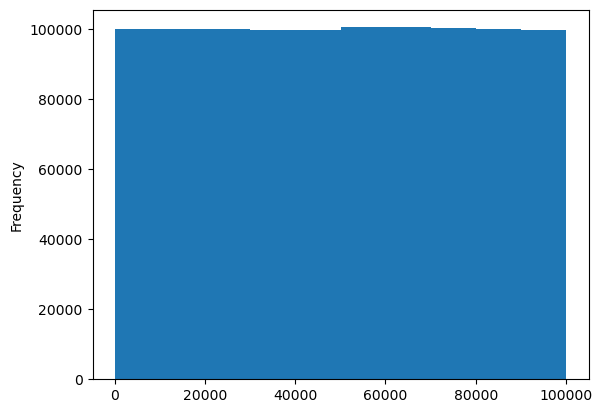

In [242]:
# continuous uniform distribution because we don't know the average starting balance for bettors. 
df['start_balance'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

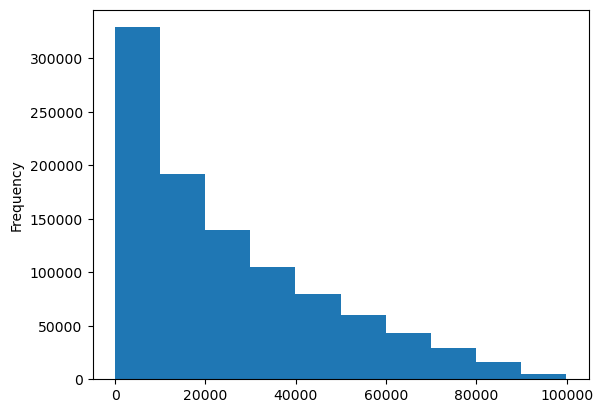

In [243]:
# the distribution for starting bets looks like right skewed
# most likely because we set the random generator to be from 0 to start_bal so getting og_bets of less than the start bal pushes us to be right skewed
df['og_bet'].plot.hist()

<AxesSubplot:xlabel='startbal_bucket'>

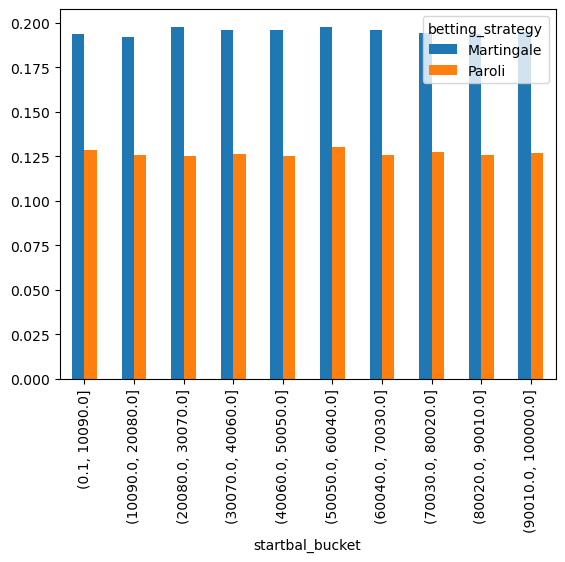

In [244]:
# looking at the mean of winning rates, Martingale is winning in every bucket
df.groupby(['startbal_bucket','betting_strategy']).mean()['is_positive'].unstack().plot(kind='bar')

<AxesSubplot:xlabel='startbal_bucket'>

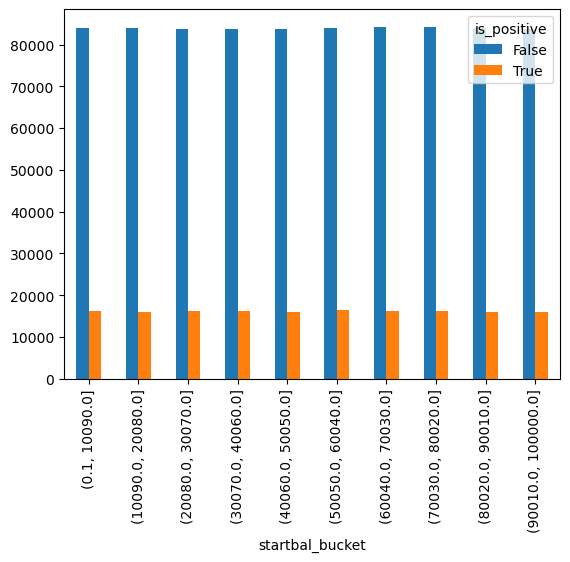

In [245]:
# but even with different starting buckets, the overall positive rate stays flat
df.groupby(['startbal_bucket','is_positive']).count()['simulation'].unstack().plot(kind='bar')


<AxesSubplot:xlabel='startbal_bucket'>

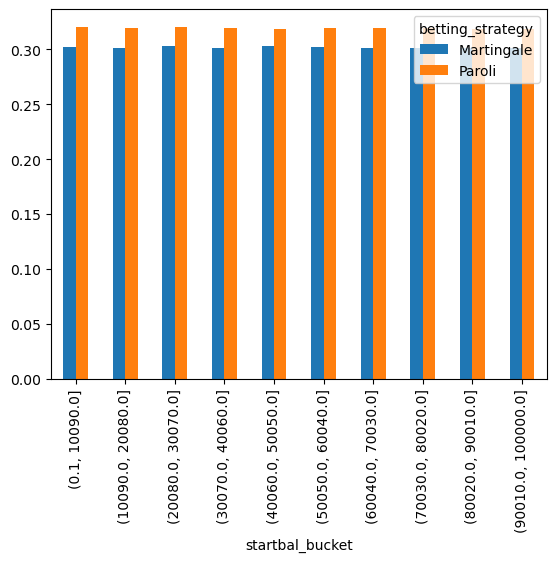

In [247]:
# of winning rolls mostly lines up. 
df.groupby(['startbal_bucket','betting_strategy']).mean()['% winning rolls'].unstack().plot(kind='bar')

In [248]:
print(f'mean number of bets til the paroli method reaches 0 = {paroli_df[paroli_df["is_positive"] == False]["number_of_bets"].mean()}')

print(f'mean number of bets til the martingale method reaches 0 = {martingale_df[martingale_df["is_positive"] == False]["number_of_bets"].mean()}')

mean number of bets til the paroli method reaches 0 = 14.153047734047599
mean number of bets til the martingale method reaches 0 = 21.215251416078704


### Martingale Deep Dive

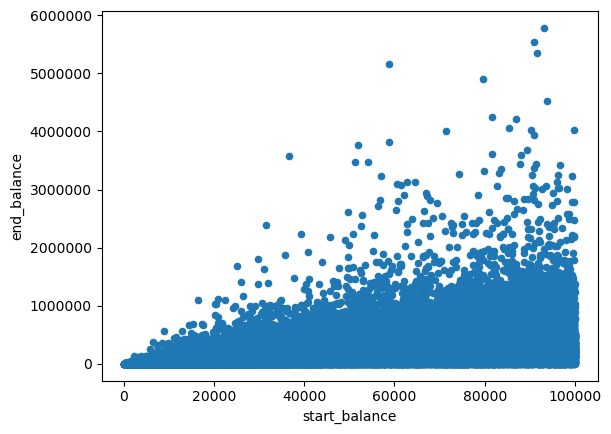

In [249]:
# exploring starting balance vs ending balance with Martingale
martingale_df[martingale_df['is_positive'] == True].plot.scatter(x='start_balance',y='end_balance')
plt.ticklabel_format(style='plain')

In [250]:
martingale_df[martingale_df['is_positive'] == True]['end_balance'].describe().apply(lambda x: format(x, 'f'))

count      97646.000000
mean      169828.515710
std       228607.133424
min            3.141197
25%        40595.838300
50%       104798.785901
75%       213091.055292
max      5785932.073975
Name: end_balance, dtype: object

## Paroli Deep Dive

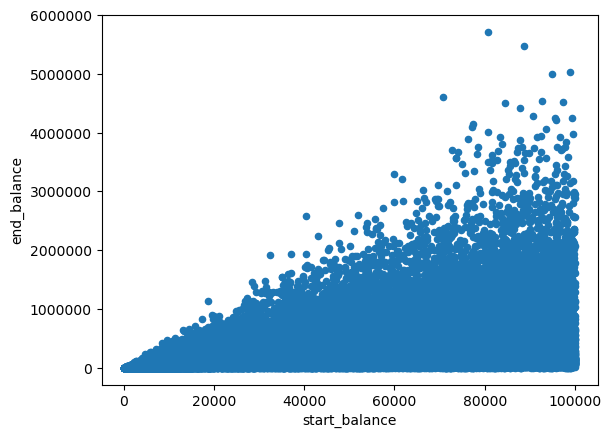

In [251]:
# exploring starting balance vs ending balance with Martingale
paroli_df[paroli_df['is_positive'] == True].plot.scatter(x='start_balance',y='end_balance')
plt.ticklabel_format(style='plain')

In [252]:
paroli_df[paroli_df['is_positive'] == True]['end_balance'].describe().apply(lambda x: format(x, 'f'))

count      63395.000000
mean      231229.954160
std       393293.397003
min            8.000000
25%        32575.500000
50%        79975.000000
75%       241892.000000
max      5716256.000000
Name: end_balance, dtype: object